# Stationarity of the stochastic GW background


This notebook explores the stationarity of the stochastic GW background.

We are specifically interested in the quantity $a^{(n)}(t)$ which quantifies the influence of the stochastic GW backround on the $n$-th pulsar in a PTA. Please see the PTA P3 paper for a full definition of terms. We will assume that the reader of this notebook is somewhat familiar with the notation of PTA P3.



This notebook explores the shape of the curve $\langle a^{(n)}(t) a^{(n')}(t')\rangle (\tau)$ where $\tau = t - t'$ 


The $\langle \rangle$ brackets represent an ensemble average s.t. $\langle x\rangle = \frac{1}{N} \sum_{i=1}^N x_i$

The function $a^{(n)}(t)$ is the summation over $M$ individual GW sources applied to the $n$-th pulsar


### Summary of steps

To get the curve $\langle a^{(n)}(t) a^{(n')}(t')\rangle (\tau)$ we do the following:

* Specify two random pulsars, $n=1$, $n=2$.
* Specify an "observation plan", i.e. total timespan and cadence of the data (equivalently the discrete timesteps $t_k$)
* Specify the number of GW sources $M = 100$ 
* For a specific realisation of  $M = 100$ GW sources:
    * Compute $a^{(n=1)}(t)$
    * Compute $a^{(n=2)}(t)$
    * Calculate the product $\mathcal{A}(\tau) = a^{(n=1)}(t=0) \cdot a^{(n=2)}(t')$. 
* Repeat for J realisations of the M sources, and average



### Use notes

T


# 0. Imports and setup

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import sys
sys.path.append("../src") # Make modules in src easily available here by adding to path

In [32]:
#some useful quantities
year = 3.154e7 # in seconds
week = 604800  # in seconds

# 1. Defining the multiverse


To start, lets define the probability distributions over the 7 GW parameters.

To generate a BBH we sample each of these 7 parameters once.

To generate a universe, a population of BBH, we sample each of the 7 parameters M times.


In [33]:
from BH_population import Universe

#Define the parameters for the power law over Ω
alpha = -3.0 #Exponent of the power law for the PDF of Ω
Ω_min = 1/(10*year) #lower bound on the Ω power law distribution. Set by Tobs
Ω_max = 1/(week)  #upper bound on the Ω power law distribution. Set by dt
M = int(1e4)

universe_i = Universe(alpha,Ω_min,Ω_max,M) #this is a realisation of the universe



(array([6.567e+03, 2.230e+03, 7.850e+02, 2.780e+02, 7.900e+01, 4.000e+01,
        1.000e+01, 4.000e+00, 4.000e+00, 3.000e+00]),
 array([-8.49877227, -8.26383387, -8.02889548, -7.79395708, -7.55901868,
        -7.32408029, -7.08914189, -6.85420349, -6.6192651 , -6.3843267 ,
        -6.1493883 ]),
 <BarContainer object of 10 artists>)

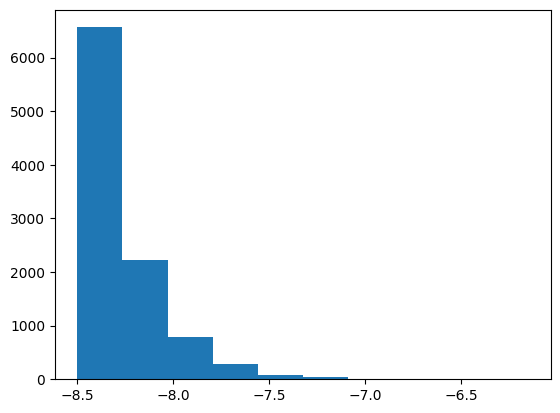

In [34]:
import matplotlib.pyplot as plt 
import numpy as np 
plt.hist(np.log10(universe_i.Ω))

# 2. Defining the PTA

In [35]:
from PTA import PTA 
Tobs = 10*year 
dt = 1*week
pulsars = PTA(Tobs=Tobs,dt=dt,seed=1)


# 3. Calculate $a(t)$

In [36]:
from calculate_gw import GW

SGWB = GW(universe_i,pulsars)
a = SGWB.compute_a()
a_jax = SGWB.compute_a_jax()

In [37]:
a 

array([[-162.2668694 ,  -37.73079692],
       [-161.12966868,  -38.46786688],
       [-160.18898873,  -39.23209718],
       ...,
       [  52.88696135,  -71.38619244],
       [  52.58170745,  -70.78350028],
       [  52.29001274,  -70.3036204 ]], shape=(522, 2))

In [38]:
a_jax 

Array([[-162.2668694 ,  -37.73079692],
       [-161.12966868,  -38.46786688],
       [-160.18898873,  -39.23209718],
       ...,
       [  52.88696135,  -71.38619244],
       [  52.58170745,  -70.78350028],
       [  52.29001274,  -70.3036204 ]], dtype=float64)

In [39]:
assert np.allclose(a,a_jax)

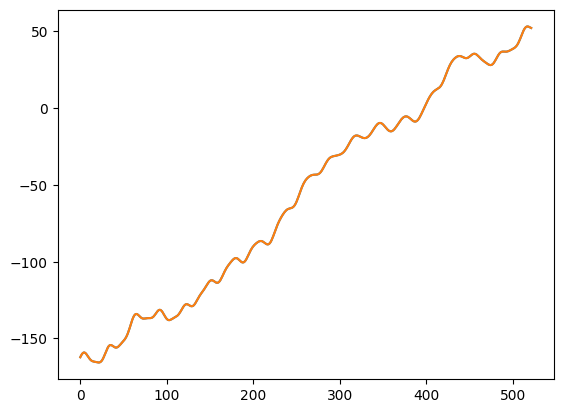

In [40]:
xx = np.arange(len(a))
yy = a[:,0]
yy1 = a_jax[:,0]
plt.plot(xx,yy) 
plt.plot(xx,yy1)

# 4. Pipeline

Lets put all this together into a single pipeline 

In [47]:

#Define the parameters for the power law over Ω
alpha = -3.0 #Exponent of the power law for the PDF of Ω
Ω_min = 1/(10*year) #lower bound on the Ω power law distribution. Set by Tobs
Ω_max = 1/(week)  #upper bound on the Ω power law distribution. Set by dt
M = int(1e4)


#Observation period
Tobs = 10*year 
dt = 1*week




def get_a_for_universe_i(pulsar_seed):

    universe_i = Universe(alpha,Ω_min,Ω_max,M) #this is a realisation of the universe
    pulsars = PTA(Tobs=Tobs,dt=dt,seed=pulsar_seed)


    #Given this universe and these pulsars, what is a(t)?
    SGWB = GW(universe_i,pulsars)
    a = SGWB.compute_a_jax()

    a1 = a[:,0]
    a2 = a[:,1]


    #1D product
    ac = a1[0]
    product = ac*a2 


    #2D product
    outer_product = np.outer(a1,a2)

    return product,outer_product



In [48]:

pulsars = PTA(Tobs=Tobs,dt=dt,seed=1)
num_times = len(pulsars.t)

In [49]:

from tqdm import tqdm

num_realisations = 1000

array_1D = np.zeros((num_times,num_realisations)) #one timeseries for every seed. We will then average over this
array_2D = np.zeros((num_times,num_times)) #2D grid for a running sum

for i in tqdm(range(num_realisations)):
    product,outer_product = get_a_for_universe_i(pulsar_seed=1)

    array_1D[:,i] = product
    array_2D += outer_product

100%|██████████| 1000/1000 [00:50<00:00, 19.87it/s]


In [53]:
from plotting import plot_1d,plot_2d

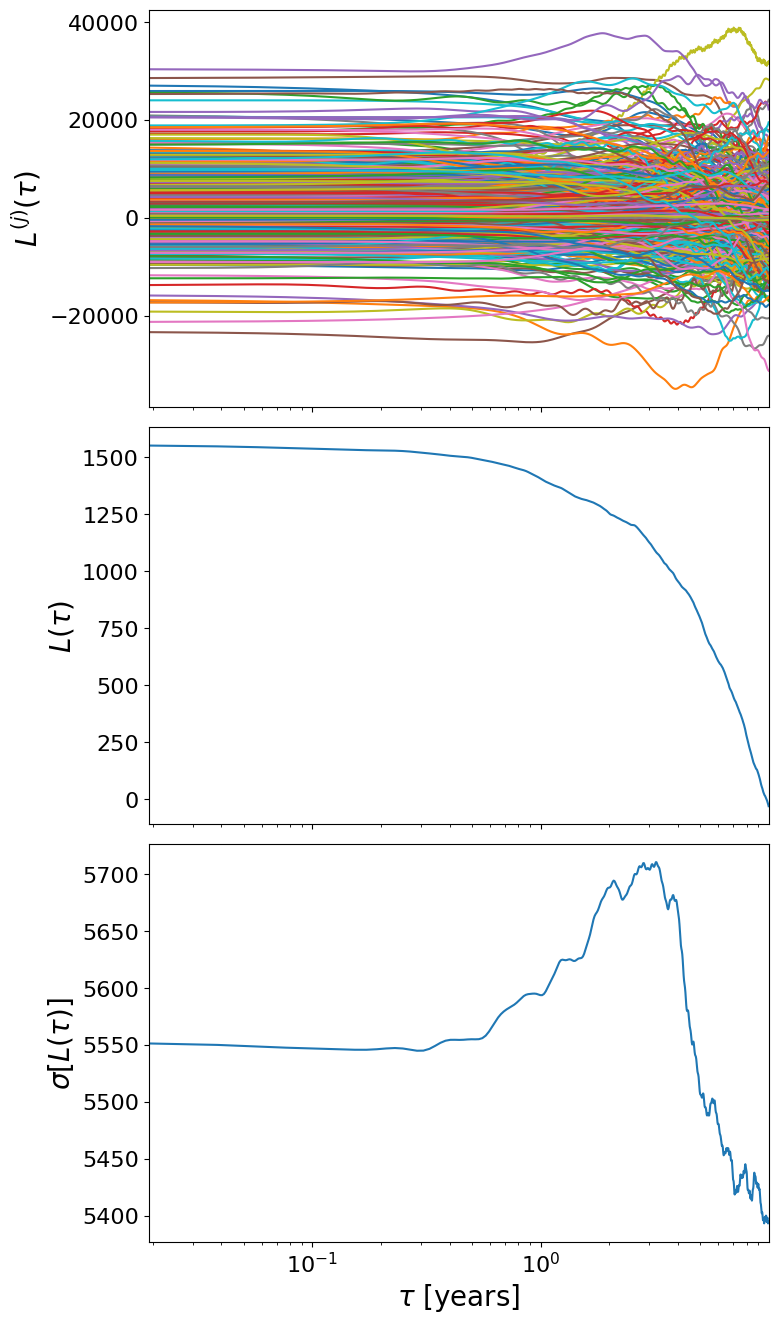

In [54]:
plot_1d(pulsars.t,array_1D)

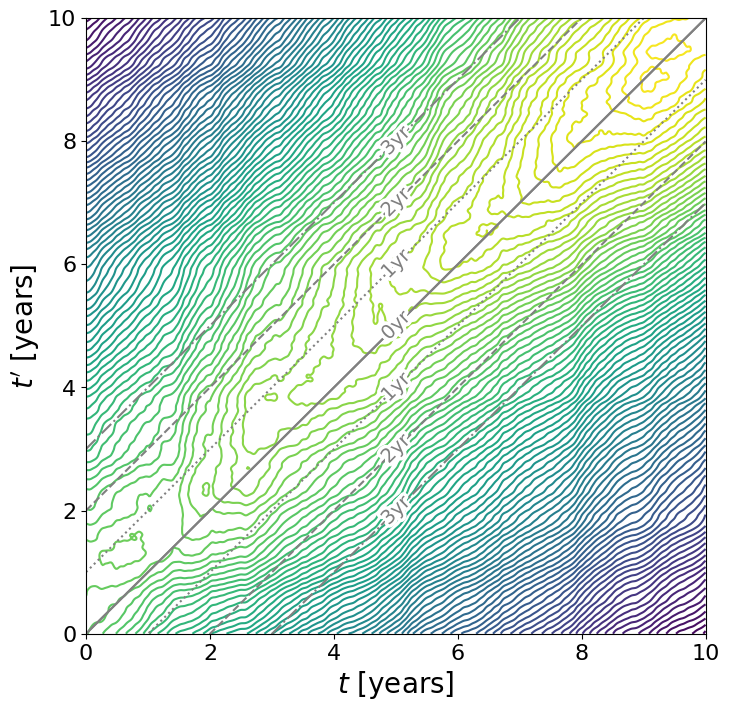

In [55]:
plot_2d(pulsars.t,array_2D)